In [14]:
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import tflearn

In [15]:
mnist_data_folder='./data'
mnist=input_data.read_data_sets(mnist_data_folder, one_hot=True)

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


In [16]:
print('训练集信息：')
print(mnist.train.images.shape,mnist.train.labels.shape)
print('测试集信息：')
print(mnist.test.images.shape,mnist.test.labels.shape)
print('验证集信息：')
print(mnist.validation.images.shape,mnist.validation.labels.shape)

训练集信息：
(55000, 784) (55000, 10)
测试集信息：
(10000, 784) (10000, 10)
验证集信息：
(5000, 784) (5000, 10)


In [17]:
batch_x=mnist.test.images[:256]
batch_y=mnist.test.labels[:256]

In [18]:
img1 = cv2.imread('1_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img2 = cv2.imread('2_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img3 = cv2.imread('3_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img4 = cv2.imread('4_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img5 = cv2.imread('5_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img6 = cv2.imread('6_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img7 = cv2.imread('7_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img8 = cv2.imread('8_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img9 = cv2.imread('9_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
img0 = cv2.imread('0_0.jpg', cv2.IMREAD_GRAYSCALE).reshape(1, -1) / 255.0
imgs = np.vstack(
    [img1, img2, img3, img4, img5, img6, img7, img8, img9, img0])
imgs[imgs < 0.015] = 0

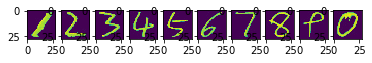

In [19]:
plt.subplot(1,10,1).imshow(img1.reshape(28, 28))
plt.subplot(1,10,2).imshow(img2.reshape(28, 28))
plt.subplot(1,10,3).imshow(img3.reshape(28, 28))
plt.subplot(1,10,4).imshow(img4.reshape(28, 28))
plt.subplot(1,10,5).imshow(img5.reshape(28, 28))
plt.subplot(1,10,6).imshow(img6.reshape(28, 28))
plt.subplot(1,10,7).imshow(img7.reshape(28, 28))
plt.subplot(1,10,8).imshow(img8.reshape(28, 28))
plt.subplot(1,10,9).imshow(img9.reshape(28, 28))
plt.subplot(1,10,10).imshow(img0.reshape(28, 28))

plt.show()

In [20]:
def conv_net(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    #第一个卷积层:padding=SAME,保证输出的feature map与输入矩阵的大小相同
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    #max_pooling,窗口大小为2x2
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    #dropout:每个神经元有p_keep_conv的概率以1/p_keep_conv的比例进行归一化,有(1-p_keep_conv)的概率置为0
    l1 = tf.nn.dropout(l1, p_keep_conv)

    #第二个卷积层
    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    #第三个卷积层
    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    #将所有的feature map合并成一个2048维向量
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)
    #后面两层为全连接层
    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)
    pyx = tf.matmul(l4, w_o)
    
    return pyx

In [21]:
#初始化参数
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [22]:
batch_size = 128
test_size = 256

In [23]:
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, 28, 28, 1)  # 将每张图片用一个28x28的矩阵表示,(55000,28,28,1)
teX = teX.reshape(-1, 28, 28, 1)  # 将每张图片用一个28x28的矩阵表示,(1000,28,28,1)

In [24]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

In [25]:
w = init_weights([3, 3, 1, 32])       # 第一层卷积核大小为3x3,输入一张图,输出32个feature map
w2 = init_weights([3, 3, 32, 64])     # 第二层卷积核大小为3x3,输入32个feature map,输出64个feature map
w3 = init_weights([3, 3, 64, 128])    # 第三层卷积核大小为3x3,输入64个feature map,输出128个feature map
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 10])         # FC 625 inputs, 10 outputs (labels)

In [26]:
p_keep_conv = tf.placeholder("float") # 卷积层的dropout概率
p_keep_hidden = tf.placeholder("float")# 全连接层的dropout概率
py_x = conv_net(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

In [27]:
#初始化变量
# init = tf.initialize_all_variables()
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))# 交叉熵目标函数
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)#RMSPro算法最小化目标函数

#评估模型
predict_op = tf.argmax(py_x, 1)#返回每个样本的预测结果

In [17]:
# Launch the graph in a session
import time
tmp_time = time.time()
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(3):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})
        #test
        test_indices = np.arange(len(teX)) 
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         p_keep_conv: 1.0,
                                                         p_keep_hidden: 1.0})))
    saver = tf.train.Saver()  ##保存的API
    save_path = saver.save(sess,"./Test_MNIST_CNN.ckpt")
    print("save model:{0} Finished".format(save_path))
print('time cost:', time.time() - tmp_time)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 0.96484375
save model:./Test_MNIST_CNN.ckpt Finished
time cost: 87.15041494369507


In [75]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()  ##保存的API
# load_path = saver.restore(sess,"model/Test_MNIST_CNN.ckpt")  #load上一步训练的参数
with tf.Session() as sess:
    #sess.run(init) #不使用训练好的参数
    load_path = saver.restore(sess,"./Test_MNIST_CNN.ckpt")  #load上一步训练的参数
    
    pred = sess.run(predict_op, feed_dict={X: td.reshape(-1, 28, 28, 1), p_keep_conv: 1.0, p_keep_hidden: 1.0})
    print("Testing Result:", pred)

INFO:tensorflow:Restoring parameters from ./Test_MNIST_CNN.ckpt
Testing Result: [0 0 0 0 7 1 1 1 2 8 2 2 3 3 3 3 4 4 4 4 5 5 5 5 8 0 6 0 7 7 7 2 8 8 8 8 9
 9 9 9]


In [118]:
_y = np.zeros((55000, 7))
yy = np.hstack([trY, _y])
yy.shape
import os
nums = os.listdir('jpg/')
td = []
tl = []
lbl = [[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]
for num in nums:
    jpgs = os.listdir(os.path.join('jpg', num))
    for jpg in jpgs:
        fname = os.path.join('jpg', num, jpg)
        pic = 1 - cv2.imread(fname, cv2.IMREAD_GRAYSCALE) / 255.0
        td.append(pic)
        tl.append(lbl[int(num)])
td = np.array(td)
tl = np.array(tl)

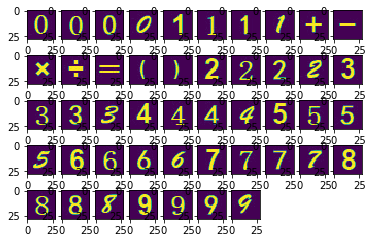

In [119]:
for i in range(1, 48):
    plt.subplot(5, 10, i)
    plt.imshow(td[i-1])
plt.show()

In [121]:
# Launch the graph in a session
import time
tmp_time = time.time()
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(3):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: np.vstack([trX[start:end], td.reshape(-1, 28, 28, 1)]), Y: np.vstack([trY[start:end], tl]),
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})
        #test
        test_indices = np.arange(len(teX)) 
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         p_keep_conv: 1.0,
                                                         p_keep_hidden: 1.0})))
    saver = tf.train.Saver()  ##保存的API
    save_path = saver.save(sess,"./Test_MNIST_CNN.ckpt")
    print("save model:{0} Finished".format(save_path))
print('time cost:', time.time() - tmp_time)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [82]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()  ##保存的API
# load_path = saver.restore(sess,"model/Test_MNIST_CNN.ckpt")  #load上一步训练的参数
with tf.Session() as sess:
    #sess.run(init) #不使用训练好的参数
    load_path = saver.restore(sess,"./Test_MNIST_CNN.ckpt")  #load上一步训练的参数
    
    pred = sess.run(predict_op, feed_dict={X: td.reshape(-1, 28, 28, 1), p_keep_conv: 1.0, p_keep_hidden: 1.0})
    print("Testing Result:", pred)

INFO:tensorflow:Restoring parameters from ./Test_MNIST_CNN.ckpt
Testing Result: [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9
 9 9 9]


In [131]:
td = td.reshape(-1, 28, 28, 1)
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 17])
w = init_weights([3, 3, 1, 32])       # 第一层卷积核大小为3x3,输入一张图,输出32个feature map
w2 = init_weights([3, 3, 32, 64])     # 第二层卷积核大小为3x3,输入32个feature map,输出64个feature map
w3 = init_weights([3, 3, 64, 128])    # 第三层卷积核大小为3x3,输入64个feature map,输出128个feature map
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 17])         # FC 625 inputs, 10 outputs (labels)
# Launch the graph in a session
import time
tmp_time = time.time()
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(3):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: np.vstack([trX[start:end], td]), Y: np.vstack([yy[start:end], tl]),
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})
            sess.run(train_op, feed_dict={X: trX[start:end], Y: yy[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})
        #test
        test_indices = np.arange(len(teX)) 
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         p_keep_conv: 1.0,
                                                         p_keep_hidden: 1.0})))
    saver = tf.train.Saver()  ##保存的API
    save_path = saver.save(sess,"./Test_MNIST_CNN.ckpt")
    print("save model:{0} Finished".format(save_path))
print('time cost:', time.time() - tmp_time)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


InvalidArgumentError: Shape [-1,28,28,1] has negative dimensions
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-cd0236d76ba5>", line 1, in <module>
    X = tf.placeholder("float", [None, 28, 28, 1])
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,28,28,1] has negative dimensions
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [112]:
np.vstack([trX[start:end], td.reshape(-1, 28, 28, 1)]).shape

(175, 28, 28, 1)

In [123]:
trX[start:end].shape

(128, 28, 28, 1)

In [128]:
td.shape

(47, 28, 28, 1)

In [124]:
yy.shape

(55000, 17)

In [126]:
tl.shape

(47, 17)